In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress

[Load and process the data](#cell1)

[Survival time in the job vs. Deparment type and Company](#cell2)

[Seniority vs Survival time in the job](#cell3)

<a id='cell1'></a>

### Load the data and Engineer Features

In [2]:
employee_df = pd.read_csv('employee_retention_data.csv')
employee_df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


How many employees do we have? Are all employees unique? As you see the answer is yes. How many different companies, departments and seniority levels are there?

In [3]:
print(employee_df.shape[0])
print('Unique employees:', employee_df['employee_id'].nunique())
print('Unique departments:',employee_df['dept'].nunique())
print('Uniuqu seniority levels:',employee_df['seniority'].nunique())
print('Company_ids:',employee_df['company_id'].nunique())

24702
Unique employees: 24702
Unique departments: 6
Uniuqu seniority levels: 31
Company_ids: 12


In [4]:
employee_df['employed'] = employee_df['quit_date'].isnull().astype(int)
employee_df['quit_censored']= employee_df['quit_date']
employee_df['quit_censored'].fillna('2015-12-14',inplace=True)

employee_df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employed,quit_censored
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,0,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,1,2015-12-14
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,2014-08-22


Create a column called survival to measure how much people survive in a job 

In [5]:
employee_df['join_date'] = pd.to_datetime(employee_df['join_date'])
employee_df['quit_date'] = pd.to_datetime(employee_df['quit_date'])
employee_df['quit_censored'] = pd.to_datetime(employee_df['quit_censored'])
employee_df['survival'] = ((employee_df['quit_censored'] - employee_df['join_date'])/np.timedelta64(1, 'D')).astype(int)
employee_df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employed,quit_censored,survival
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,2015-10-30,585
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,0,2014-04-04,340
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,1,2015-12-14,427
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0,2013-06-07,389
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,2014-08-22,1040


What percent of the people in the data are still employed? It looks like 45% of the people are still employed.

In [6]:
employee_df['employed'].mean()*100

45.308072220872802

What is the distribution of survival  times?

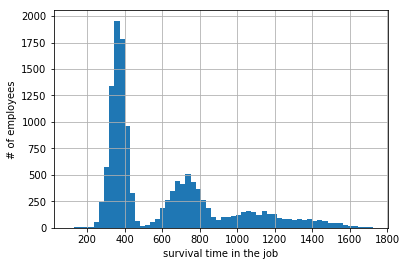

In [7]:
employee_df.loc[employee_df['employed']==0,'survival'].hist(bins=60)
plt.ylabel('# of employees')
plt.xlabel('survival time in the job')

Based on this graph there seems to be at least two-three different kinds of people. A lot of people do last about a year, then quit. Then, there are a group of pople who survive about two years an so on.

How are the distribution of departments in our data? 

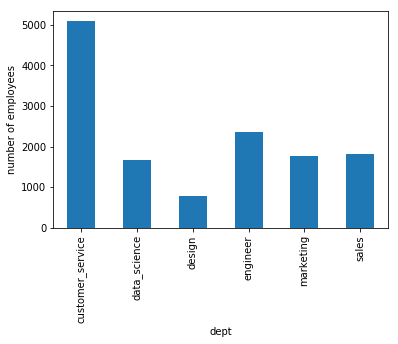

In [8]:
df = employee_df.loc[employee_df['employed']==0].groupby('dept')['dept'].count()
plt.ylabel('number of employees')
df.plot.bar()

Looks like most of our employee are in customer service jobs.

<a id='cell2'></a>

###  Survival time in the job vs. Deparment type and Company

What is the median survival of people in different departments and in different companies?

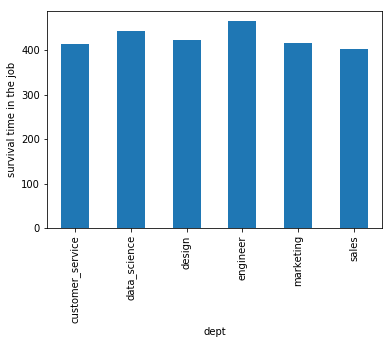

In [9]:
df = employee_df.loc[employee_df['employed']==0].groupby('dept')['survival'].median()
plt.ylabel('survival time in the job')
df.plot.bar()

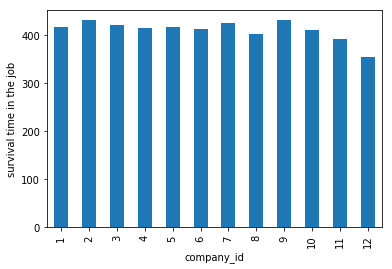

In [10]:
df = employee_df.loc[employee_df['employed']==0].groupby('company_id')['survival'].median()
plt.ylabel('survival time in the job')
df.plot.bar()

Interestingly median survival time doesn't really change much by department. Sales employees have the shortest survival time. The same is true for median survival time vs company_id. However Company 12 is especially struggling with keeping employees. 

Let's look at this another way. We have previously seen that some people last in their job only for a year. Is there something particular about them? Can we split them up the emplyees by how much they have stayed in their job and examine them?

0.00611033649432
r-squared: 0.00611033649432


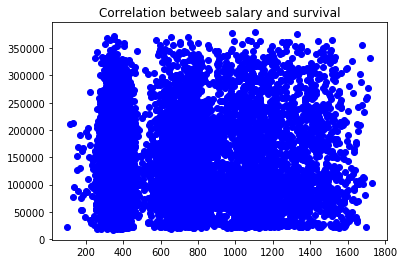

In [11]:
# matplotlib plotting
plt.title('Correlation betweeb salary and survival')
 
y = employee_df.loc[employee_df['employed']==0,'salary']
x = employee_df.loc[employee_df['employed']==0,'survival']

correlation = np.corrcoef(x, y)[0,1]
rsq = correlation**2
plt.scatter(x,y, marker='o', c='b',) # plot my data points

print(rsq)

slope, intercept, r_value, p_value, std_err = linregress(x,y)

print("r-squared:", r_value**2)


Let's actually check whether there might be a correlation between the salary and and survival time in one of the departments

In [12]:
for dept in employee_df.loc[employee_df['employed']==0,'dept'].unique().tolist():

    y = employee_df.loc[(employee_df['employed']==0)&(employee_df['dept']==dept),'salary']
    x = employee_df.loc[(employee_df['employed']==0)&(employee_df['dept']==dept),'survival']

    correlation = np.corrcoef(x, y)[0,1]
    rsq = correlation**2
    print(dept,rsq)

customer_service 0.00980511833109
marketing 5.75824593524e-05
data_science 0.0253706253123
engineer 0.0351568269133
sales 0.000433652004599
design 0.000891503056843


0.0351568269133


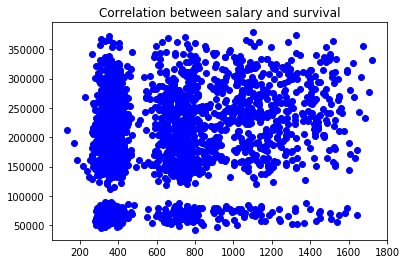

In [13]:
# matplotlib plotting
plt.title('Correlation between salary and survival')

dept = 'engineer'
y = employee_df.loc[(employee_df['employed']==0)&(employee_df['dept']==dept),'salary']
x = employee_df.loc[(employee_df['employed']==0)&(employee_df['dept']==dept),'survival']

correlation = np.corrcoef(x, y)[0,1]
rsq = correlation**2
plt.scatter(x,y, marker='o', c='b',) # plot my data points

print(rsq)

Looks like there is not correlation between salary and survival in engineering deparments.

<a id='cell3'></a>

### Seniority vs Survival time in the job:

What about seniority vs survival?

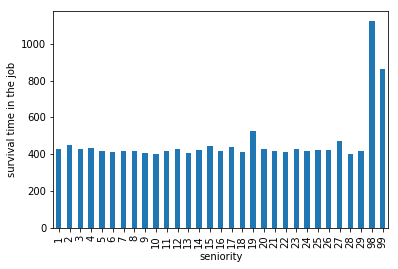

In [14]:
df = employee_df.loc[employee_df['employed']==0].groupby('seniority')['survival'].median()
plt.ylabel('survival time in the job')
df.plot.bar()

For some reason seniority levels 98 and 99 really have long survival times, these could be CEOs.

### Company size vs. employee turnover

To be able look at the relationship between company size and employee turnover, we would need to add a feature called company size. 

In [15]:
# Our start and end dates
print(employee_df['join_date'].max())
print(employee_df['join_date'].min())

2015-12-10 00:00:00
2011-01-24 00:00:00


In [22]:
employee_headcount = pd.DataFrame(columns=['day','company_id','employee_headcount'])
for single_day in pd.date_range(start='2011/01/24',end='2015/12/13'):
    df = pd.DataFrame(employee_df[(employee_df['join_date']<=single_day)&(single_day<employee_df['quit_censored'])].groupby('company_id')['employee_id'].count())
    df['day']=single_day
    df.rename(index=str,columns={'employee_id':'employee_headcount'},inplace=True)
    df.reset_index(inplace=True)
    employee_headcount = employee_headcount.append(df)

    
employee_headcount.set_index('day',inplace=True)
employee_headcount.head()  

,company_id,employee_headcount
day,,
2011-01-24,1,25
2011-01-24,2,17
2011-01-24,3,9
2011-01-24,4,12
2011-01-24,5,5


Since the size of the companies are so different from each other, let's plot them in three groups

company_id
1    Axes(0.125,0.125;0.775x0.755)
2    Axes(0.125,0.125;0.775x0.755)
3    Axes(0.125,0.125;0.775x0.755)
Name: employee_headcount, dtype: object

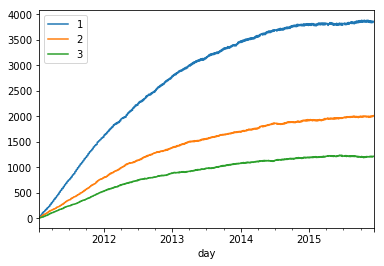

In [23]:
companies = ['1','2','3']
employee_headcount[employee_headcount['company_id'].isin(companies)].groupby('company_id')['employee_headcount'].plot(legend=True)

company_id
10    Axes(0.125,0.125;0.775x0.755)
4     Axes(0.125,0.125;0.775x0.755)
5     Axes(0.125,0.125;0.775x0.755)
6     Axes(0.125,0.125;0.775x0.755)
7     Axes(0.125,0.125;0.775x0.755)
8     Axes(0.125,0.125;0.775x0.755)
9     Axes(0.125,0.125;0.775x0.755)
Name: employee_headcount, dtype: object

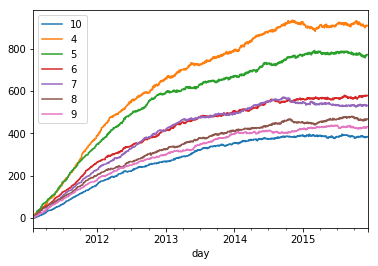

In [24]:
companies = [str(i) for i in range(4,11)]
employee_headcount[employee_headcount['company_id'].isin(companies)].groupby('company_id')['employee_headcount'].plot(legend=True)

company_id
11    Axes(0.125,0.125;0.775x0.755)
12    Axes(0.125,0.125;0.775x0.755)
Name: employee_headcount, dtype: object

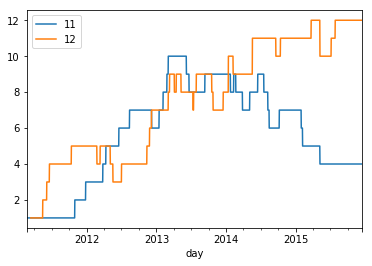

In [25]:
companies = [str(i) for i in range(11,13)]
employee_headcount[employee_headcount['company_id'].isin(companies)].groupby('company_id')['employee_headcount'].plot(legend=True)

In [26]:
employee_turnover = pd.DataFrame(columns=['year','company_id','average_head_count','quit_count'])
for single_day in pd.date_range(start='2011/01/24',end='2015/12/13'):
    df = pd.DataFrame(employee_df[(employee_df['join_date']<=single_day)&(single_day<employee_df['quit_censored'])].groupby('company_id')['employee_id'].count())
    df['day']=single_day
    df.rename(index=str,columns={'employee_id':'employee_headcount'},inplace=True)
    df.reset_index(inplace=True)
    employee_headcount = employee_headcount.append(df)

    
employee_headcount.set_index('day',inplace=True)
employee_headcount.head()  


In [28]:
pd.date_range(start='2011',end='2012')



DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2011-12-23', '2011-12-24', '2011-12-25', '2011-12-26',
               '2011-12-27', '2011-12-28', '2011-12-29', '2011-12-30',
               '2011-12-31', '2012-01-01'],
              dtype='datetime64[ns]', length=366, freq='D')